In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 

def read_binarry(file_path):
    import struct
    import math

    power = []
    age = []
    coordinate_x = []
    coordinate_y = []
    angle_tetta = []
    angle_phi = []
    energy = []
    time = []

    with open(file_path, 'rb') as binary_file:
        for i in range(100000):
            binary_file.read(4 * 5)

            tetta = struct.unpack('f', binary_file.read(4))[0]
            angle_tetta.append(tetta)

            phi = struct.unpack('f', binary_file.read(4))[0]
            angle_phi.append(phi)

            x0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_x.append(x0)

            y0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_y.append(y0)

            binary_file.read(4 * 5)

            power_eas = struct.unpack('f', binary_file.read(4))[0]
            power.append(math.log10(power_eas))

            age_eas = struct.unpack('f', binary_file.read(4))[0]
            age.append(age_eas)

            binary_file.read(4 * 1565)
            energy_release = struct.unpack('f' * 36, binary_file.read(4 * 36))
            energy.append(energy_release)

            binary_file.read(4)
            t = struct.unpack('f' * 144, binary_file.read(4 * 144))
            threshold_time = t[::4]
            time.append(threshold_time)

    # Собираем всё в DataFrame
    df = pd.DataFrame({
        'power': power,
        'age': age,
        'x': coordinate_x,
        'y': coordinate_y,
        'tetta': angle_tetta,
        'phi': angle_phi,
        'energy': energy,
        'threshold_time': time,
    })

    return df


In [96]:
#Заморозка 
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
random_state = 42

In [97]:
df = read_binarry("spe27p_100k_2022_correct.dat")

In [98]:
df.head()

,power,age,x,y,tetta,phi,energy,threshold_time
0,4.166507,1.444716,13.572407,37.022316,37.367474,47.313324,"(0.10191129148006439, 11.324358940124512, 13.0...","(-1.0, 91830.7265625, 91844.828125, 91830.7109..."
1,4.933104,1.430547,40.330677,-61.980999,28.912228,236.400421,"(10.563158988952637, 0.0, 7.604449272155762, 1...","(61243.13671875, -1.0, 61215.59375, 61216.8359..."
2,4.133581,1.459046,-1.046695,-63.925430,37.267426,182.086060,"(0.0, 0.34477588534355164, 0.35262614488601685...","(-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 78681.062..."
3,5.190620,1.326983,40.293152,-21.836197,3.205503,201.268890,"(34.960296630859375, 40.36423873901367, 6.7627...","(52147.2421875, 52211.25, 52142.87890625, 5213..."
4,5.021614,1.336776,15.542248,10.037846,6.299241,108.097626,"(79.6240234375, 29.508312225341797, 60.4609146...","(88044.953125, 88053.078125, 88046.9453125, 88..."


In [99]:
with open("spe27p_100k_2022_correct.dat", 'rb') as f:
    print(f.read(4 * 5))

b'\x00\x00\x00\x00\x00\x00zD\x00\x00\x80?\x00\x00`A\x00\tzI'


In [100]:
len(df["energy"][0])

36

In [101]:
new_columns = pd.DataFrame(
    X_age['energy'].tolist(),
    columns=[f'energy_{i}' for i in range(36)]
)

df = pd.concat([df, new_columns], axis=1)

In [102]:
new_columns = pd.DataFrame(
    X_age['threshold_time'].tolist(),
    columns=[f'threshold_time_{i}' for i in range(36)]
)

df = pd.concat([df, new_columns], axis=1)

In [103]:
df.drop(columns=["energy", "threshold_time"], inplace=True)

In [104]:
df.columns.shape

(78,)

In [105]:
X = df.drop(columns=["power", "age", "x", "y", "tetta", "phi"])

In [142]:
y_age = df["age"]

In [143]:
y_age.shape

(100000,)

In [144]:
X.shape

(100000, 72)

In [145]:
X.isna().sum().sum()

0

In [146]:
y_age.isna().sum()

0

In [147]:
#Бустинг lightgbm

In [148]:
y_age.shape

(100000,)

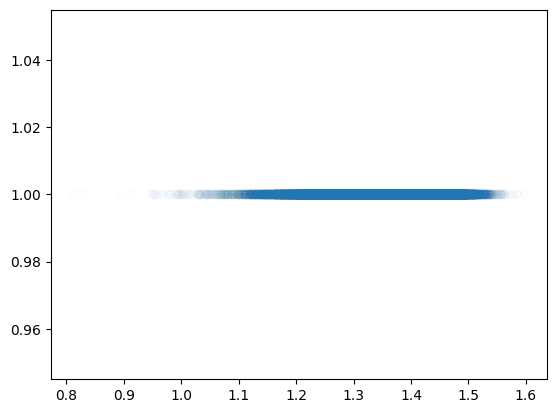

In [149]:
plt.scatter(y=[1 for i in range(y_age.shape[0])], x=y_age, alpha=0.01)

In [150]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing

In [151]:
X_train, X_test, y_age_train, y_age_test = train_test_split(X, y_age, test_size=0.2, random_state=random_state)

In [152]:
train_data = lgb.Dataset(X_train, label=y_age_train)
test_data = lgb.Dataset(X_test, label=y_age_test, reference=train_data)

In [153]:
params = {
    'objective': 'regression',       # Тип задачи - регрессия
    'metric': 'rmse',                # Метрика качества (Root Mean Squared Error)
    'boosting_type': 'gbdt',         # Алгоритм градиентного бустинга
    'num_leaves': 7,                # Максимальное количество листьев в дереве
    'learning_rate': 0.05,           # Скорость обучения
    'feature_fraction': 0.9,         # Доля случайно выбираемых признаков на каждой итерации
    'bagging_fraction': 0.8,         # Доля данных для бутстрепа
    'bagging_freq': 5,               # Частота бэггинга
    'verbose': 1,                    # Отключение выводов
    'n_jobs': -1,                    # Использовать все ядра процессора
    'random_state': 42               # Для воспроизводимости
}

In [154]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,            # Максимальное количество деревьев
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 72
[LightGBM] [Info] Start training from score 1.367758


In [155]:
y_age_preds = model.predict(X_test, num_iteration=model.best_iteration)

In [156]:
def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

metrics = evaluate_regression(y_age_test, y_age_preds)

RMSE: 0.0554
MAE: 0.0420
R²: 0.2782


In [157]:
df[["power", "age", "x", "y", "tetta", "phi"]].mean()

power      4.645768
age        1.367679
x          2.245046
y         -2.949996
tetta     32.891332
phi      179.331245
dtype: float64

In [158]:
df["age"].describe()

count    100000.000000
mean          1.367679
std           0.064083
min           0.811961
25%           1.332817
50%           1.375110
75%           1.410739
max           1.596757
Name: age, dtype: float64

In [159]:
df.head()

,power,age,x,y,tetta,phi,energy_0,energy_1,energy_2,energy_3,...,threshold_time_26,threshold_time_27,threshold_time_28,threshold_time_29,threshold_time_30,threshold_time_31,threshold_time_32,threshold_time_33,threshold_time_34,threshold_time_35
0,4.166507,1.444716,13.572407,37.022316,37.367474,47.313324,0.101911,11.324359,13.000817,23.782166,...,91763.781250,91759.656250,91774.828125,-1.000000,-1.000000,91810.023438,-1.000000,91878.492188,-1.000000,-1.000000
1,4.933104,1.430547,40.330677,-61.980999,28.912228,236.400421,10.563159,0.000000,7.604449,15.454450,...,61375.957031,-1.000000,61293.765625,61283.878906,61253.312500,61261.664062,61192.441406,61199.957031,61166.894531,61236.789062
2,4.133581,1.459046,-1.046695,-63.925430,37.267426,182.086060,0.000000,0.344776,0.352626,0.072466,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,78678.609375,78703.148438
3,5.190620,1.326983,40.293152,-21.836197,3.205503,201.268890,34.960297,40.364239,6.762777,71.258392,...,52187.480469,52178.167969,52173.789062,52171.929688,52172.902344,52173.003906,52137.703125,52150.824219,52160.316406,52141.460938
4,5.021614,1.336776,15.542248,10.037846,6.299241,108.097626,79.624023,29.508312,60.460915,105.564728,...,88065.773438,88074.195312,88085.453125,88084.914062,88094.664062,88097.500000,88057.523438,88064.109375,88071.828125,88070.187500


In [160]:
df["tetta"].describe()

count    100000.000000
mean         32.891332
std          11.876371
min           0.190070
25%          24.378988
50%          34.795225
75%          42.962389
max          49.999722
Name: tetta, dtype: float64

In [161]:
df["phi"].describe()

count    100000.000000
mean        179.331245
std         103.730651
min           0.000122
25%          90.004028
50%         179.304276
75%         268.801086
max         359.999023
Name: phi, dtype: float64